In [228]:
from typing import Callable, List
from functools import partial, reduce

import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray

plt.rcParams["figure.figsize"] = (20,10)

In [229]:
"""
Finds gradient of function fun in point x with precision h.
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
Finds "partial" gradient of function represented in the form of sum.
Calculates sum of derivatives of some terms of function fun in a row.

@param fun: list of terms of the function to find partial gradient for
@param x: point in which derivatives are calculated
@param r: list of 2 elements. 1 element shows the first term in list fun for which gradiant will be found. 2 element shows for how many terms after first term gradient will be found
@param h: precision of calculated gradients

@returns r[1] dimensional list containing sum of calculated gradients
"""
def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

"""
Generates cartesian product of points in arrays.

Это функция взята с Stack Overflow, я понятия не имею, как она работает, и не хочу иметь.
"""
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

"""
Generates data set for multiple linear regression.
Guaranteed that expected value of noise equals to 0. Every regressor is len(b) - 1 dimensional vector.
Both regressors and dependent variables lists has size equals to size.


Для облегчения понимания можно считать, что функция генерирует точки, смещённые относительно некоторой гиперплоскости вверх или вниз.

p[1:] в некотором роде задаёт нормаль к этой гиперплоскости. p[0] - смещение гиперплоскости вверх или вниз относительно начала координат, length - её длина. k или шум характеризует то, насколько сгенерированные точки будут отклоняться от гиперплоскости, которую мы приближаем. size - количество точек на гиперплоскости.

В итоге получается два массива: точки на гиперплоскости и высоты этих точек.


@param b: list characterising linear relationship between regressors (independent variables) and dependent variable. b[0] is dependent variable offset
@param k: noise (error term) max absolute value
@param size: number of points (data instances) in data set
@param r: tuple describing range in which regressors (feature) will be generated

@return list of two elements: list of regressors and list of dependent values
"""
def generate_dataset(b:List[float], k:int, size:int=50, r:tuple = (0, 10)) -> List[List[float]]:
    # t += (np.random.rand(len(t)) - 0.5) * 2 * k
    h, b = b[0], b[1:]
    dim = len(b)
    # *[t]*dim is equals to *np.tile(t, dim).reshape((dim, -1))
    regressors = np.random.rand(size, dim) * (r[1] - r[0]) + r[0]
    # Noise
    e = (np.random.rand(len(regressors)) - 0.5) * 2 * k
    dependent_var = np.sum(b * regressors, axis=1) + h + e
    return [regressors, dependent_var]

"""
! Deprecated for removing
Generates data set for multiple linear regression.
Guaranteed that expected value of noise equals to 0. Every regressor is len(b) - 1 dimensional vector.
Both regressors and dependent variables lists has size equals to len(t) ** (len(b) - 1).


Для облегчения понимания можно считать, что функция генерирует точки, смещённые относительно некоторой гиперплоскости вверх или вниз.

p[1:] в некотором роде задаёт нормаль к этой гиперплоскости. p[0] - смещение гиперплоскости вверх или вниз относительно начала координат, length - её длина. k или шум характеризует то, насколько сгенерированные точки будут отклоняться от гиперплоскости, которую мы приближаем. num - количество точек на гиперплоскости.

В итоге получается два массива: точки на гиперплоскости и высоты этих точек.


@param b: list characterising linear relationship between regressors (independent variables) and dependent variable. b[0] is dependent variable offset
@param k: noise (error term) max absolute value
@param t: list describing basis linspace for dataset

@return list of two elements: list of regressors and list of dependent values
"""
def generate_dataset_old(b:List[float], k:int, t:ndarray = np.linspace(0, 10, 50)) -> List[List]:
    # t += (np.random.rand(len(t)) - 0.5) * 2 * k
    h, b = b[0], b[1:]
    dim = len(b)
    # *[t]*dim is equals to *np.tile(t, dim).reshape((dim, -1))
    regressors = cartesian_product(*[t]*dim)
    # Noise
    e = (np.random.rand(len(regressors)) - 0.5) * 2 * k
    dependent_var = np.sum(b * regressors, axis=1) + h + e
    return [regressors, dependent_var]

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
It is pretty slow.

@param t: list of regressors
@param ft: list of dependent values

@return list of terms of generated function (every term represents distance from minimized function to one point from dataset)
"""
def generate_minimized_fun(t:List[List[float]], ft:List[float]) -> List[Callable[[List], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(a[0] + np.sum(a[1:] * t) - ft), t[i], ft[i], len(t))
        # or
        # sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(np.sum(a * np.concatenate(([1], t))) - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
Similar to generate_minimized_fun but every regressor is 1 dimensional vector (i.e. minimized function has two arguments). You should use this function only when it's necessary to plot minimized function. Function generated by generate_minimized_two_variable_fun works fine when arguments are arrays unlike generate_minimized_fun.

@param t: list of regressors
@param ft: list of dependent values

@return list of terms of generated function (every term represents distance from generated function to one point from dataset)
"""
def generate_minimized_two_variable_fun(t:List[List[float]], ft:List[float]) -> List[Callable[[List], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(a[0] + a[1] * t - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Generates function from terms. Every term is function. Every function from terms should accept equal amount of parameters.

@return function representing sum of functions from terms
"""
def fun_from_terms(terms):
    return reduce(lambda f1, f2: lambda x: f1(x) + f2(x), terms)

"""
Scales features (regressors) in data instances. Mean and standard deviation after normalization equals to 0 and 1 respectively.

Works really good when data generated by generate_dataset function.

@param t: list of data instances

@return list of data instances with normalized features
"""
def standart_scale(t):
    n = len(t)
    mean = 1 / n * np.sum(t, axis=0)
    deviation = np.sqrt(1 / n * np.sum(np.square(t - mean), axis=0))
    return (t - mean) / deviation

"""
Scales features (regressors) in data instances. Every feature value is in range [r[0], r[1]] after scaling.

As data set returned from generate_dataset distributed normally within each feature, it is better to do NOT use this scale if data set generated with generate_dataset.

@param t: list of data instances

@return list of data instances with scaled features
"""
def min_max_scale(t, r=(0, 1)):
    return (t - np.min(t, axis=0)) / (np.max(t, axis=0) - np.min(t, axis=0)) * (r[1] - r[0]) + r[0]

"""
Plots level lines of two variable function represented by terms.

@param terms: list of terms of plotted function (should be result of generate_minimized_two_variable_fun)
@param points: list of points at which plot level lines
@param offset: characterizes scale of the plot
"""
def plot_path_contours(terms:Callable[[List], float], points:List[List[float]], offset:float=40) -> None:
    min_point = points[-1]
    ax = plt.figure(figsize=(20, 20)).add_subplot()
    ax.plot(points[:, 0], points[:, 1], 'o-')
    fun = fun_from_terms(terms)
    ttX = np.linspace(min_point[0] - offset, min_point[0] + offset, 200)
    ttY = np.linspace(min_point[1] - offset, min_point[1] + offset, 200)
    X, Y = np.meshgrid(ttX, ttY)
    ax.contour(X, Y, fun([X, Y]), levels=np.sort(np.unique([fun(point) for point in points])))

"""
Plots 2d plot of two variable linear function represented by fun_coeffs. fun_coeffs[0] represents height offset.
"""
def plot_dataset_and_function(t:List[List[float]], ft:List[float], fun_coeffs:List[float]) -> None:
    plt.plot(t, ft, 'o', markersize=1)
    tt = np.linspace(np.min(t), np.max(t), 1000)
    plt.plot(tt, fun_coeffs[1] * tt + fun_coeffs[0])

"""
Finds minimum of the function sum_fun using stochastic gradient descent (sgd).

@return list of points representing path of sgd. The last point of the list is found minimum point.
"""
def sgd(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    for i in range(1, epoch):
        x = x - 1 / batch_size * scheduler(lr) * np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        points[i] = x
    return points

## Решение задачи простой линейной регрессии (одномерное пространство регрессоров)
Приближает прямую в двумерном пространстве

[ 1.64563628 -0.35993016]
[8.35436372 5.35993016]
[[0.         0.        ]
 [1.60233436 3.90138165]
 [2.32394743 4.63325483]
 [3.41243902 5.50211943]
 [3.93545301 5.44017854]
 [4.62870639 4.49685745]
 [5.15422725 5.01016947]
 [5.50221149 4.72653029]
 [6.20634687 5.40301931]
 [6.40110396 5.39831734]
 [6.79101255 4.65742769]
 [7.03844005 4.97258226]
 [7.15853571 4.75506648]
 [7.66300523 5.36545494]
 [7.68562127 5.37307163]
 [7.91688477 4.74222654]
 [8.01937597 4.9533529 ]
 [8.02084712 4.76993399]
 [8.42136674 5.3458905 ]
 [8.35436372 5.35993016]]


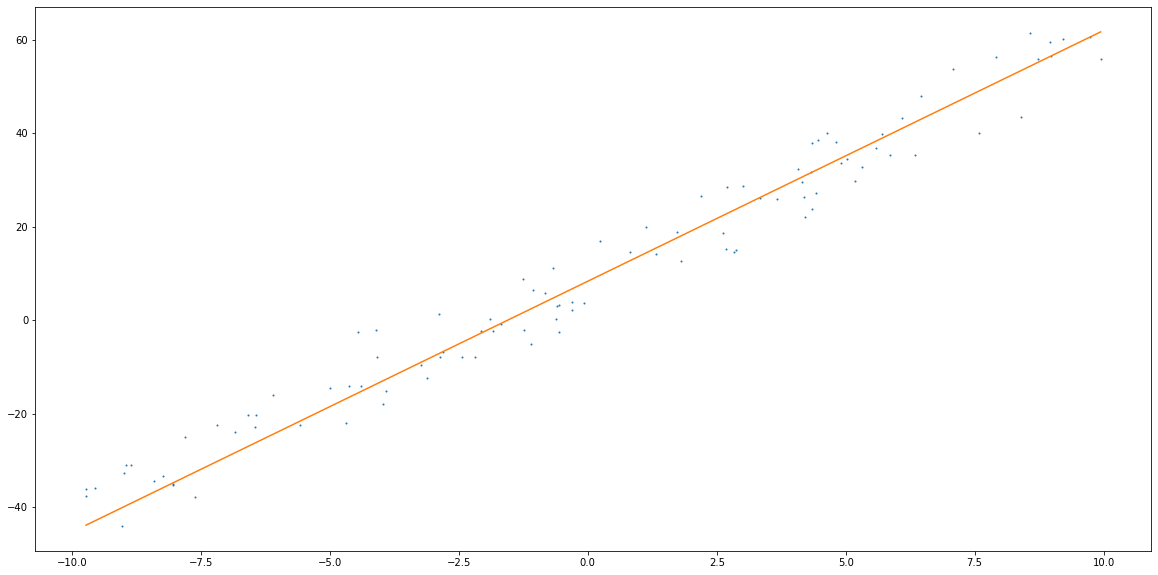

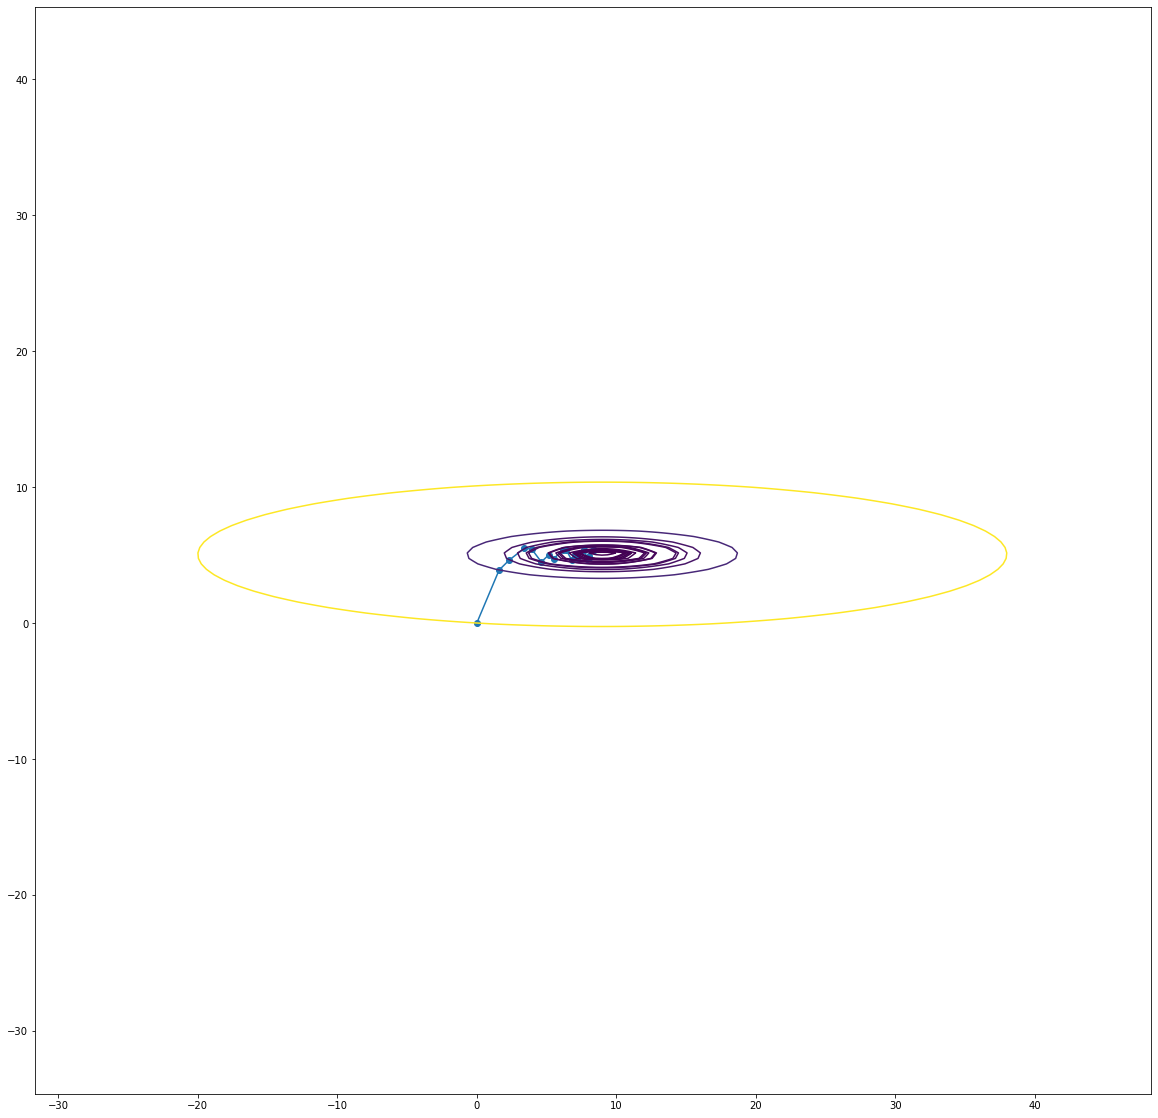

In [230]:
b = [10, 5]
t, ft = generate_dataset(b, 10, 100, (-10, 10))
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [12, 4]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)
plot_dataset_and_function(t, ft, min_point)
plot_path_contours(sum_fun, points)

## Решение задачи линейной регрессии (для двумерного пространства регрессоров)
Приближает плоскость в трёхмерном пространстве

[0.54000549 0.01296473 0.07349792]
[9.45999451 1.98703527 3.92650208]
[[0.         0.         0.        ]
 [1.54958772 0.14380222 0.78268253]
 [1.97045686 0.29063613 1.19360791]
 [2.44516764 0.46484427 1.58871467]
 [3.04097304 0.53399881 1.78114226]
 [3.67665097 0.66985536 2.00544388]
 [4.088308   0.75579208 2.25762125]
 [4.45952809 0.84714409 2.40166164]
 [4.65645857 0.90602808 2.58860724]
 [4.84610362 0.98552145 2.84032327]
 [5.11629046 1.03302966 2.94716157]
 [5.36620588 1.06818554 3.11895212]
 [5.94940583 1.15659783 3.25430823]
 [6.08521644 1.1998222  3.28445724]
 [6.49452453 1.27263756 3.3581872 ]
 [6.50966456 1.34246475 3.41649972]
 [6.7613641  1.36480375 3.48868481]
 [7.04711241 1.39555993 3.55742135]
 [7.14436263 1.42513373 3.60440101]
 [7.3996615  1.44584031 3.61701334]
 [7.51144218 1.46172649 3.70818132]
 [7.60927391 1.49821273 3.77172689]
 [7.74816211 1.53884759 3.81243641]
 [7.99553642 1.58673962 3.82276055]
 [7.99029235 1.60483352 3.87214584]
 [8.1548071  1.62187657 3.8586

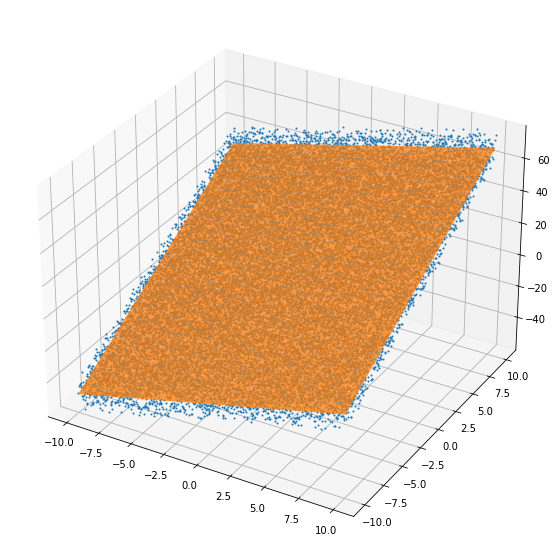

In [231]:
tt = np.linspace(-10, 10, 150)
b = [10, 2, 4]
t, ft = generate_dataset_old(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
batch_size = 20
lr = [1500, 40, 80]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot(projection='3d')
# Plots dataset
ax.plot(t[:, 0], t[:, 1], ft, 'o', markersize=1)
# Plots approximated function
X, Y = np.meshgrid(tt, tt)
ax.plot_surface(X, Y, min_point[0] + min_point[1] * X + min_point[2] * Y, alpha=0.8)

## 4-мерное пространство регрессоров

In [232]:
b = [10, 2, 4, 5, -3]
t, ft = generate_dataset(b, 10, 10000, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)
# print(t)
# SGD params
x = np.zeros(5)
epoch = 50
batch_size = 3
lr = [7500, 120, 160, 200, 120]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)

[-5.01460184 -0.740434    0.78856992  0.02569296  0.20354683]
[15.01460184  2.740434    3.21143008  4.97430704 -3.20354683]
[[ 0.          0.          0.          0.          0.        ]
 [30.77418603  2.6781076   5.19223746  3.31456929 -4.15662832]
 [13.40932689  1.41127862  5.71099161  6.7924501  -4.2897897 ]
 [ 7.94300519  1.88180864  5.35502481  5.3786537  -3.8209822 ]
 [14.7884775   2.36259951  4.45638136  4.2658784  -2.96495173]
 [12.11928642  2.67023483  3.57963978  5.02942795 -3.03231531]
 [ 9.7901698   2.44408581  3.71639328  5.23191115 -3.15060707]
 [11.14060334  2.40431642  3.67961562  4.35466824 -3.10891291]
 [ 9.9098392   2.34307726  3.73929853  4.21580678 -3.14388871]
 [10.46403907  2.10771557  4.19474951  4.07979353 -3.1609242 ]
 [14.89755791  2.67590965  3.39366221  4.65694882 -3.85359335]
 [ 6.39446042  1.75977083  5.05248477  4.72827498 -3.22467888]
 [11.67950189  2.15989094  3.89483754  5.46691956 -2.74980497]
 [13.72351331  2.12365422  4.0966309   5.40822521 -2.7662

## 100-мерное пространство регрессоров

In [233]:
n = 101
b = np.random.randint(-10, 10, n)
t, ft = generate_dataset(b, 10, 1000000, (-10, 10))
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(n)
epoch = 50
batch_size = 20
lr = 120

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)

[-5.03030077 -4.72936633  3.2440375   5.51918018 -6.4424918  -7.801097
  7.8607867   3.02720323  1.52943123  2.20475548 -3.87093538  7.14573954
 -4.82701789 -8.00137977 -6.22967257 -2.67503052 -6.18165773  3.4578739
  3.58961171 -1.73286854  7.66067648 -5.97279961  5.22045961 -4.75097323
  4.35531731 -1.0012935   5.04628697 -7.38481236  6.08128131  6.83013914
  1.62282219 -3.46605682  3.97522845  2.00624105  4.62674088 -3.87007732
  2.90157064 -0.70688331  7.62914849 -6.54679208 -5.99102513  6.45790966
  0.47248035  4.9833101  -1.91601613  5.66911118  1.17271957  6.60913246
 -3.26498882 -8.07013155  0.32275213 -7.85849845  5.74022399  4.87984255
 -3.05201662  4.40551675 -1.96573433 -2.79203958  1.5026159  -5.8408869
  1.44785916  2.77768636 -2.99677441 -3.80527554 -6.61222749  2.66570976
 -6.28574807 -2.4131225  -4.36328599  2.05327099 -7.0076727  -4.95877825
 -4.78696403 -0.59976555 -0.90636689  1.34376782 -0.88099143 -5.33773941
 -2.06165572 -4.16766427 -6.80247156 -3.56800891 -0.437

## Сходимость в зависимости от размера batch
Двумерное пространство регрессоров

[[ 2.62676276 -0.18277886  0.4454743 ]
 [ 1.97149573 -0.06443549  0.08066635]
 [ 2.03756763 -0.13398589 -0.02743869]
 [ 1.63557732  0.03290102 -0.03278494]
 [ 1.25972417 -0.05984396 -0.02121877]
 [ 1.28899359  0.04527303 -0.10011799]
 [ 1.13140825 -0.04030646 -0.0335054 ]
 [ 1.17155561  0.04564339 -0.09833889]
 [ 0.98629911 -0.02069271 -0.00881936]
 [ 1.29374015  0.04917179 -0.06617615]
 [ 0.93217303 -0.00606394 -0.01560161]
 [ 1.32567738  0.04943567 -0.03862233]
 [ 0.87049453  0.01694086 -0.03247173]
 [ 1.23381135  0.05604788 -0.02038612]
 [ 0.7893631   0.01934981 -0.04399808]
 [ 1.17965094  0.05566838 -0.02918896]
 [ 0.81661122  0.03678652 -0.0400313 ]
 [ 1.1609267   0.05137526 -0.02649166]
 [ 0.84571449  0.0365687  -0.01604988]
 [ 1.18639416  0.05145168 -0.02838263]
 [ 0.81924411  0.04106434 -0.01456915]
 [ 1.17582525  0.05304176 -0.02864468]
 [ 0.84695624  0.0418495  -0.01594307]
 [ 1.11865903  0.05585983 -0.01895282]
 [ 0.91467774  0.03226244 -0.01703804]
 [ 1.07761463  0.05533169

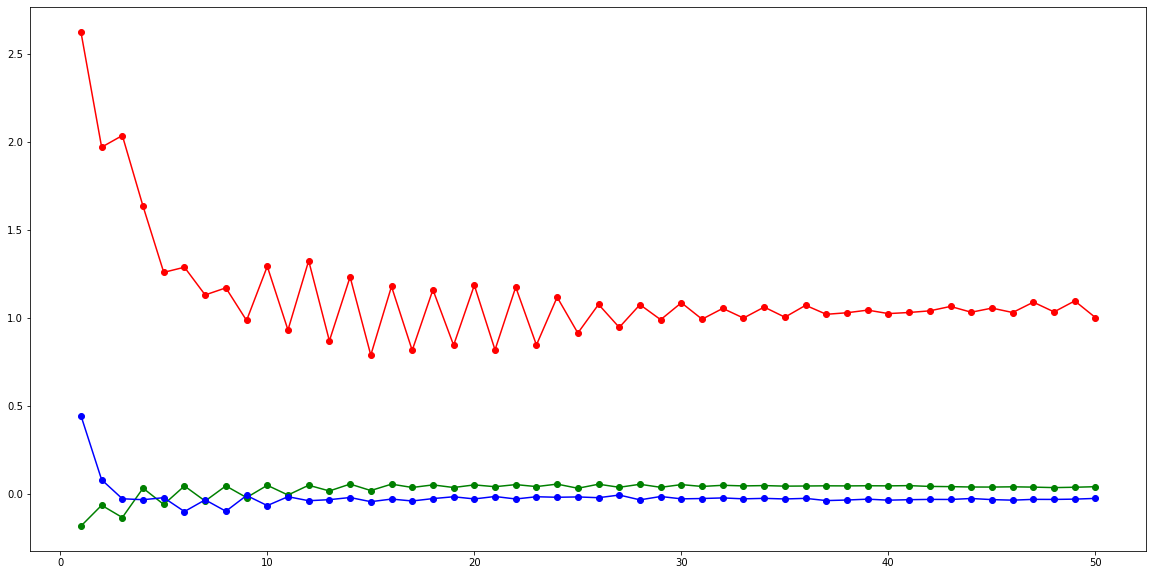

In [234]:
tt = np.linspace(-10, 10, 10)
b = [50, 2, 15]
t, ft = generate_dataset_old(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
lr = [10, 0.2, 0.4]
scheduler = lambda lr: np.array(lr) * np.exp(-0.01)

# n <= np.power(len(tt), 2)
n = 50
min_points = []
for batch_size in range(1, n + 1):
    min_points.append(sgd(sum_fun, x, epoch, batch_size, lr, scheduler=scheduler)[-1])

min_points = np.array(min_points)
print(b - min_points)
print(min_points)

plt.plot(np.linspace(1, n, n), (b - min_points)[:, 0], '-o', color='red')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 1], '-o', color='green')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 2], '-o', color='blue')

## Решение задачи простой линейной регрессии с использованием standart scaler
Видно, что после scaling функция изменяется более одинаково по всем измерениям. Значительное улучшение сходимости. Отсутствие необходимости подбирать lr по каждой переменной.

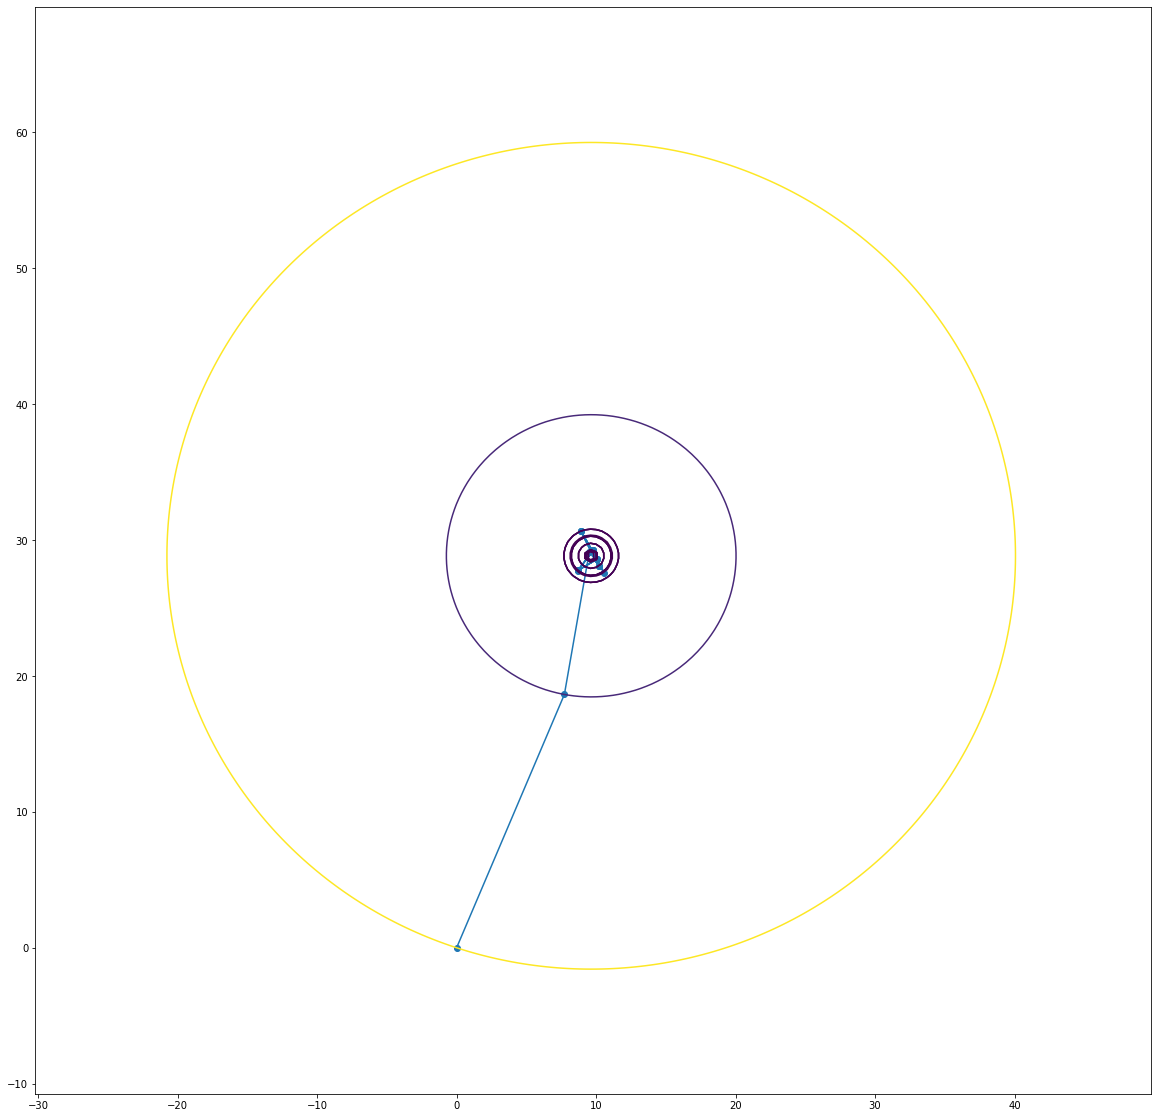

In [235]:
b = [10, 5]
t, ft = generate_dataset(b, 10, 100, (-10, 10))
t = standart_scale(t)
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = 70

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

# Invalid data because scaling
# print(b - min_point)
# print(min_point)
# print(points)
#
# plot_dataset_and_function(t, ft, min_point)

plot_path_contours(sum_fun, points)

## Сравнение до и после standart scaling

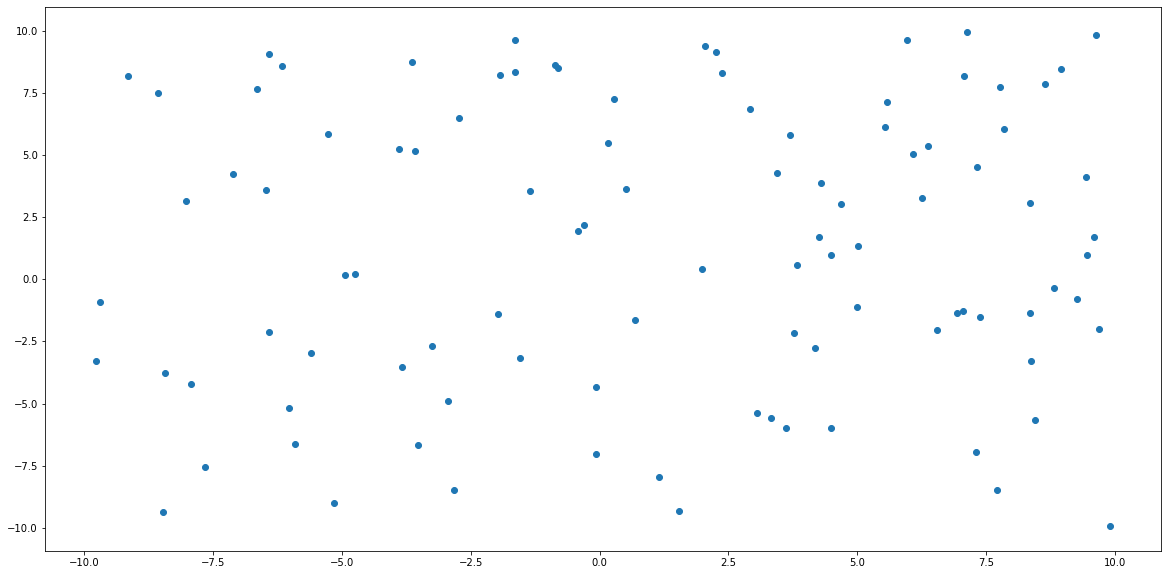

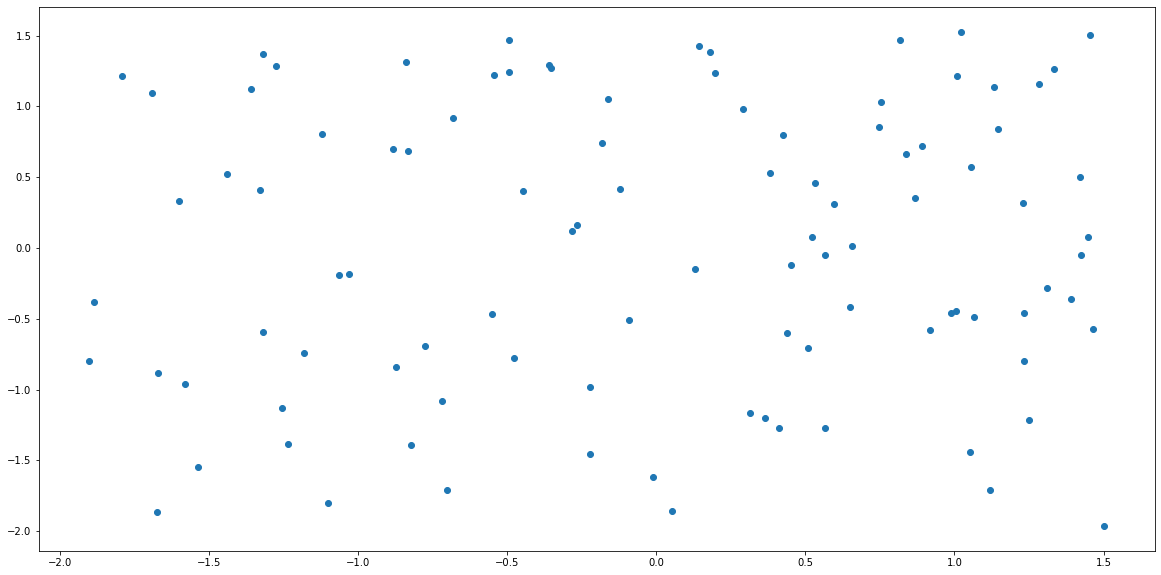

In [236]:
b = [10, -3, 5]
t, ft = generate_dataset(b, 3, 100, (-10, 10))

ax = plt.figure().add_subplot()
ax.plot(t[:, 0], t[:, 1], 'o')

t = standart_scale(t)
ax = plt.figure().add_subplot()
ax.plot(t[:, 0], t[:, 1], 'o')

## SGM with momentum

[-0.63558491 -0.20842338]
[9.36441509 4.79157662]
[[0.         0.        ]
 [0.37355768 4.47782938]
 [1.20584119 8.05939617]
 [1.86277717 6.24661949]
 [2.78325084 3.41384762]
 [3.529692   3.259621  ]
 [4.21839398 5.06652998]
 [4.92725391 6.05373009]
 [5.66927721 6.09300834]
 [6.2286905  5.60288832]
 [6.88251485 4.16558616]
 [7.35439147 3.66662306]
 [7.82799289 4.91206721]
 [8.12790253 5.2579998 ]
 [8.44877671 5.52628363]
 [8.56583134 5.28361406]
 [8.62090069 4.86306471]
 [8.88066219 4.53010649]
 [9.20617506 4.64124346]
 [9.36441509 4.79157662]]


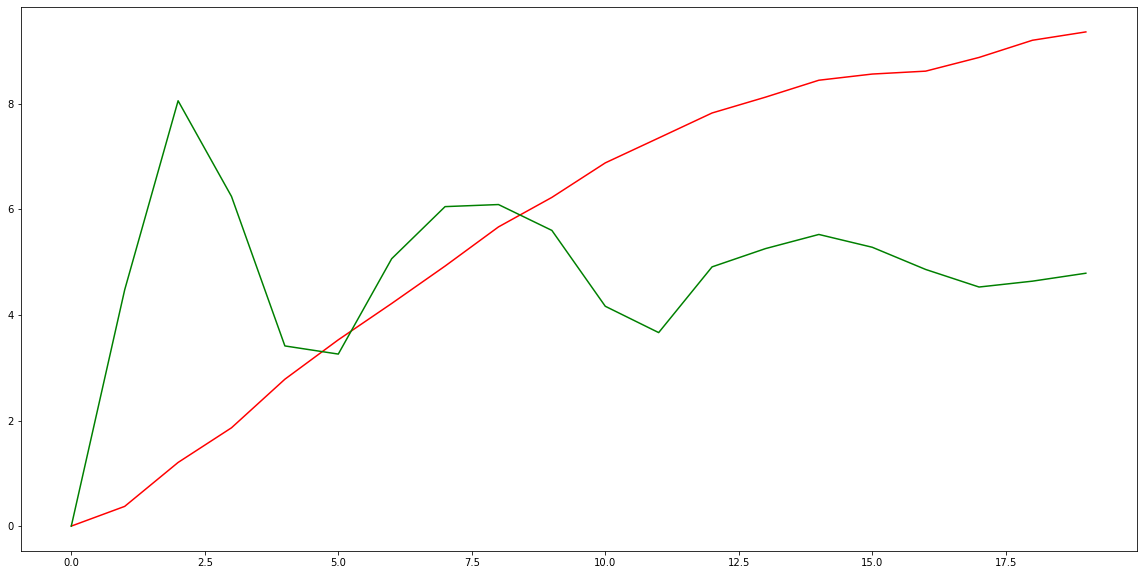

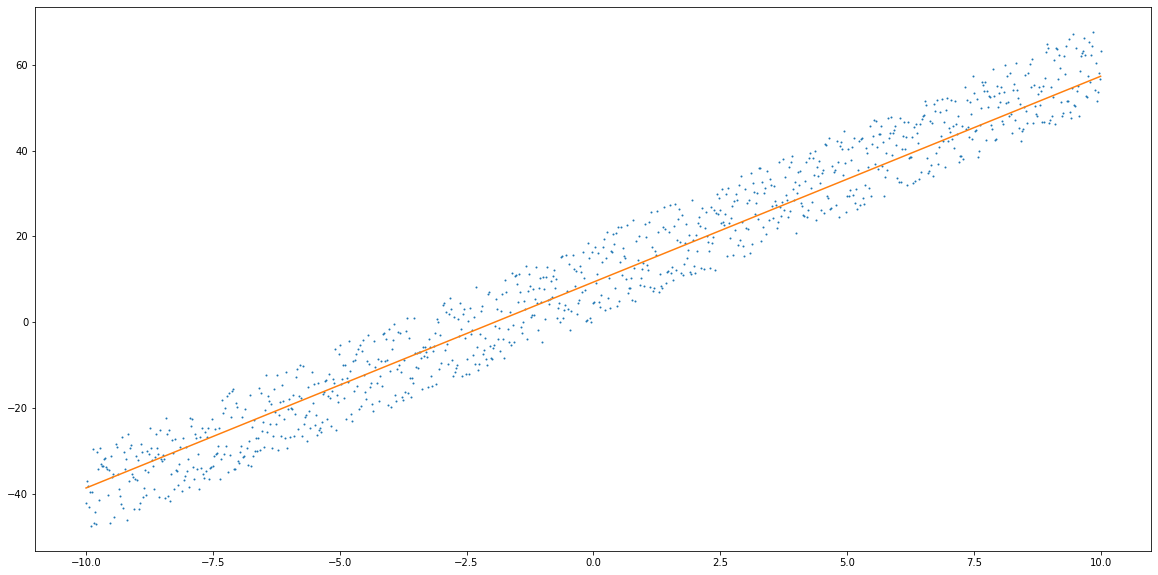

In [237]:
"""
Finds minimum of the function using stochastic gradient descent with momentum.

Единственное отличие от функции sgd в том, что добавился параметр b.
"""
def sgd_momentum(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    g = np.array(grad_appr(sum_fun, x, [0, batch_size]))
    for i in range(1, epoch):
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x, [i * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points[i] = x
    return points

tt = np.linspace(-10, 10, 1000)
a = [10, 5]
t, ft = generate_dataset_old(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [60, 30]
b = [0.5]

points = sgd_momentum(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(min_point - a)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## Nesterov SGD

[-1.04448584  0.04422261]
[8.95551416 5.04422261]
[[0.         0.        ]
 [0.88262923 5.96561566]
 [1.77381773 8.25061278]
 [2.84582959 6.2590586 ]
 [3.77311139 4.19792896]
 [4.47984096 3.84887928]
 [5.18722809 4.89964237]
 [5.85111253 5.28240733]
 [6.36113864 5.29332341]
 [6.83982196 4.87962468]
 [7.3126836  4.6009306 ]
 [7.74924681 4.87634146]
 [8.12847775 5.24178338]
 [8.40079397 5.22744263]
 [8.65408935 4.932375  ]
 [8.85430598 4.78401283]
 [8.86652485 4.72617965]
 [8.87011461 4.95852048]
 [8.86833995 5.1653502 ]
 [8.95551416 5.04422261]]


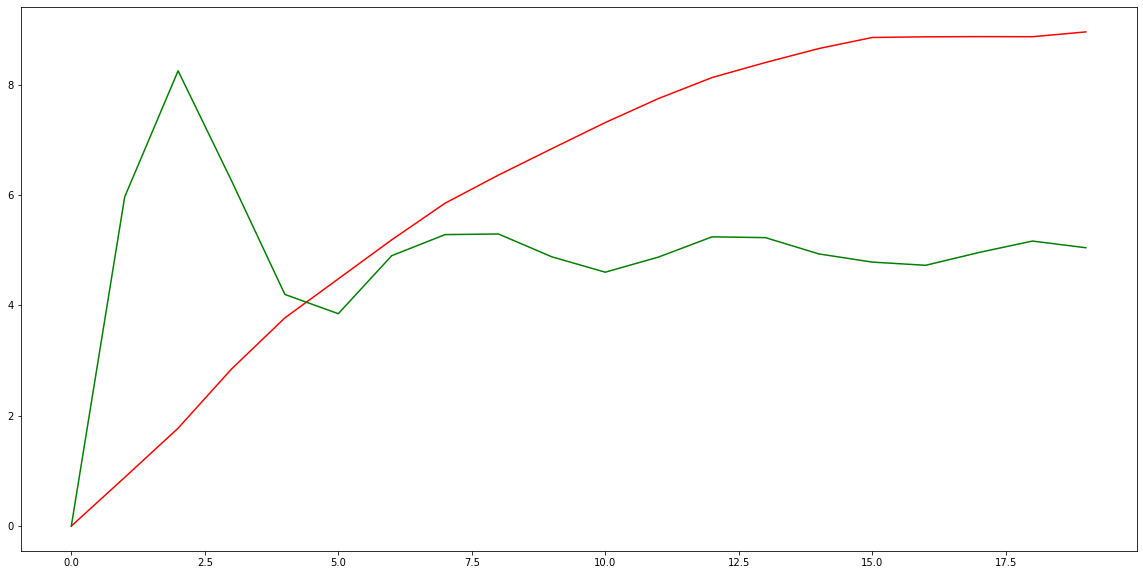

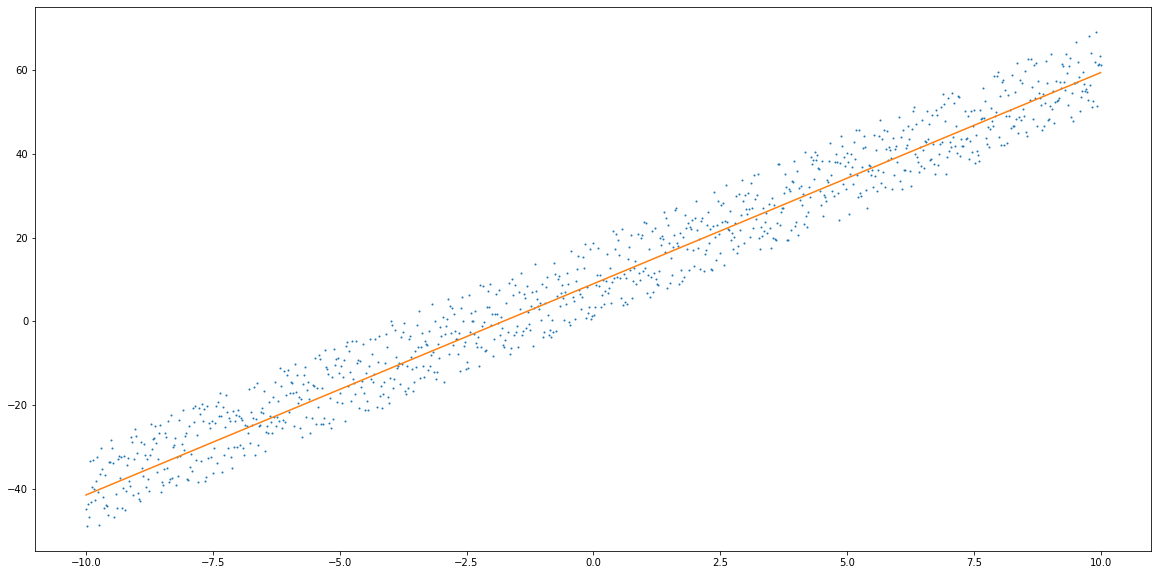

In [238]:
"""
Finds minimum of the function using stochastic gradient descent with Nesterov algorithm.
"""
def sgd_nesterov(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    g = 0
    for i in range(1, epoch):
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x - b * g, [(i - 1) * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points[i] = x
    return points

tt = np.linspace(-10, 10, 1000)
a = [10, 5]
t, ft = generate_dataset_old(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 60
lr = [60, 30]
b = [0.5]

points = sgd_momentum(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(min_point - a)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with AdaGrad

[-0.12889139  0.29897368]
[20.12889139  4.70102632]
[[ 0.          0.        ]
 [20.         20.        ]
 [27.98325362  1.12045499]
 [22.5704054   5.66530079]
 [21.21970877  4.79606987]
 [20.81482547  5.00199229]
 [21.59894695  4.92150398]
 [21.0991268   5.08136372]
 [20.3853773   4.90894891]
 [19.1370849   4.75341553]
 [18.97600244  4.92185564]
 [20.98098383  5.0218285 ]
 [19.05632625  4.58316305]
 [19.17812964  5.13468572]
 [18.87241258  4.90194   ]
 [21.24970727  5.25691345]
 [19.22996834  4.69764451]
 [20.21200428  5.18775798]
 [20.45741031  5.15450202]
 [20.12889139  4.70102632]]


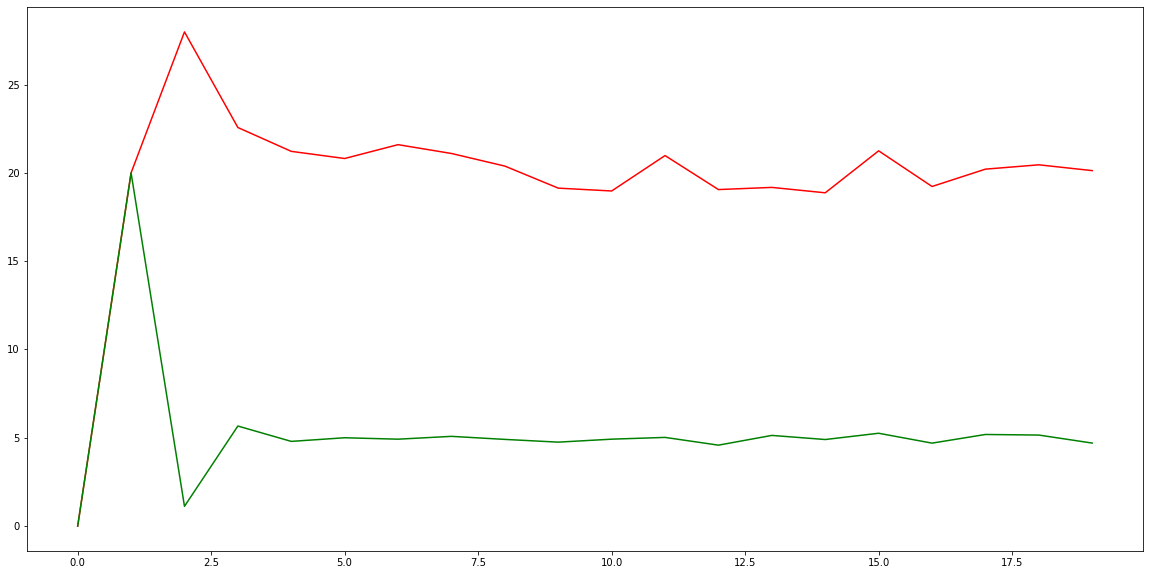

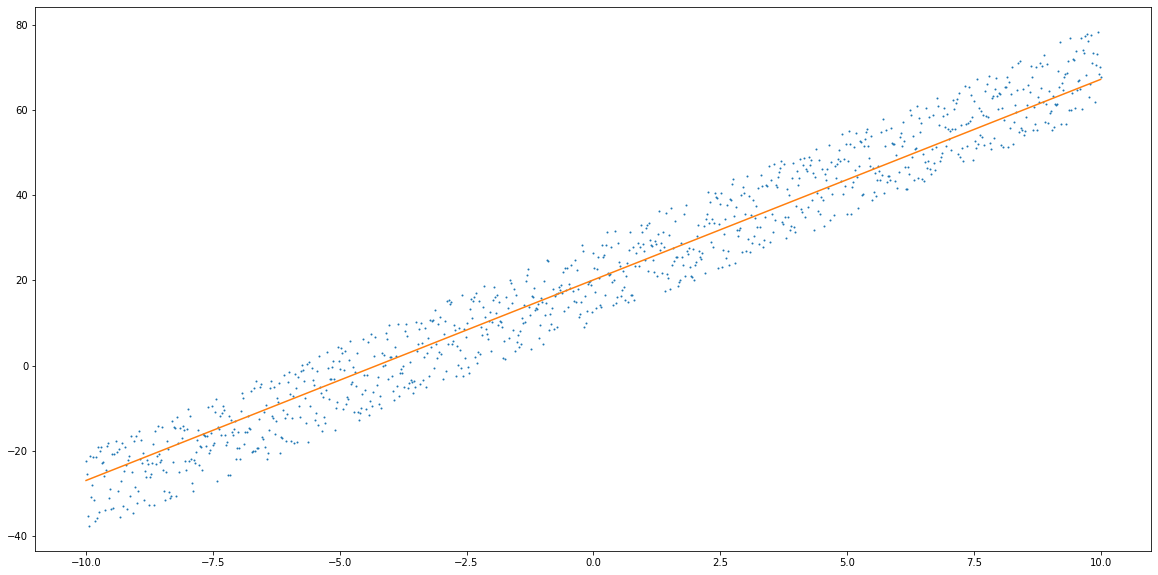

In [239]:
"""
Finds minimum of the function using stochastic gradient descent with AdaGrad (adaptive gradient).

Единственное отличие от функции sgd в том, что добавился параметр b.
"""
def sgd_adagrad(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v += np.square(g)
        x = x - 1 / np.sqrt(v) * 1 / batch_size * scheduler(lr) * g
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [20, 5]
t, ft = generate_dataset_old(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [1000]

points = sgd_adagrad(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with RMSProp

[-0.05905445  0.05974435]
[15.05905445  4.94025565]
[[ 0.          0.        ]
 [ 4.42718872  4.42718872]
 [ 7.26510864  4.70873701]
 [ 9.18795255  4.84928515]
 [10.91016928  5.3410041 ]
 [11.78440206  5.09203118]
 [12.41781096  5.02529666]
 [12.98737821  4.85278605]
 [13.71841662  5.52881401]
 [14.04682659  4.78914878]
 [13.97629326  5.23746955]
 [14.55842527  4.67849347]
 [14.9976892   5.01942294]
 [14.79852038  5.35340416]
 [15.45483293  5.01524918]
 [14.98423871  5.018609  ]
 [14.5118638   4.60084332]
 [13.94326118  4.95202877]
 [14.76496623  5.14983152]
 [15.05905445  4.94025565]]


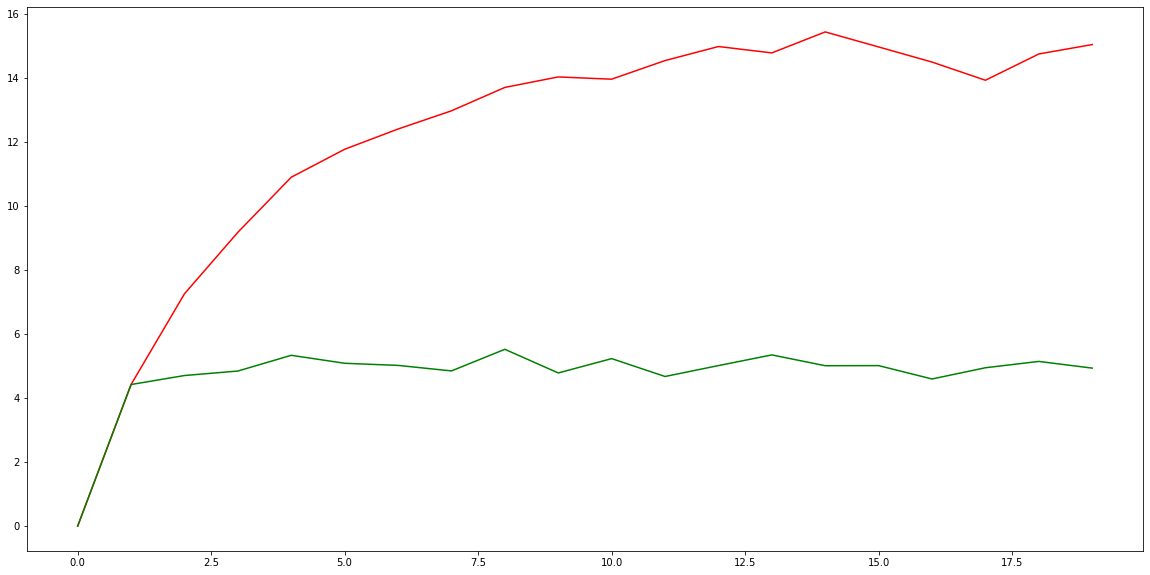

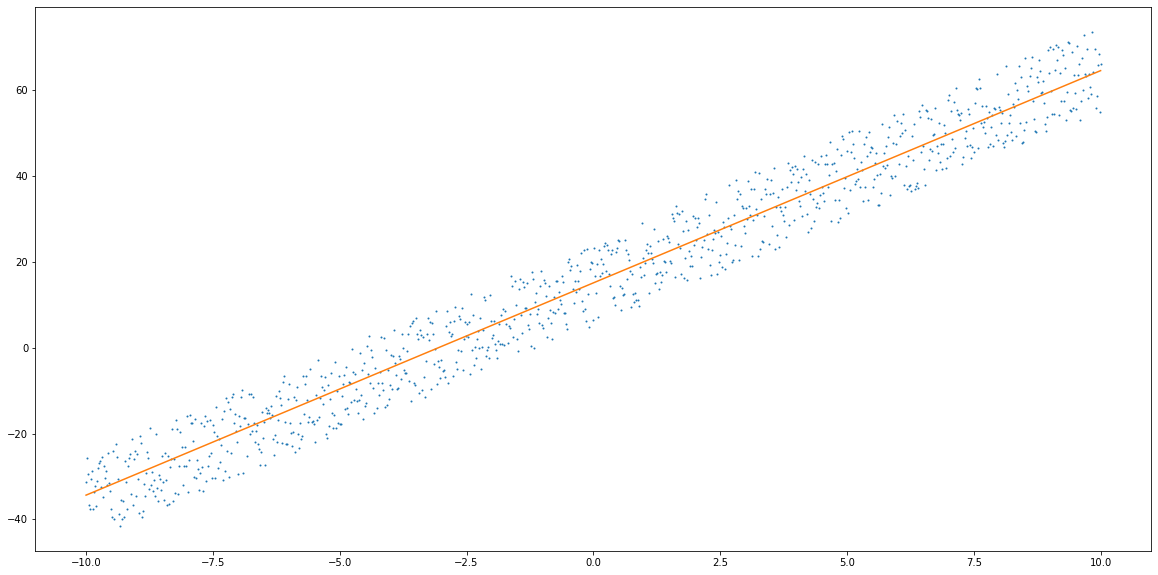

In [240]:
"""
Finds minimum of the function using stochastic gradient descent with rmsprop.
"""
def sgd_rmsprop(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    b = np.array(b)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v = b * v + (1 - b) * np.square(g)
        x = x - 1 / np.sqrt(v) * 1 / batch_size * scheduler(lr) * g
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [15, 5]
t, ft = generate_dataset_old(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [70]
b = [0.9]

points = sgd_rmsprop(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with Adam

[-0.35133348  0.12227627]
[15.35133348  4.87772373]
[[ 0.          0.        ]
 [ 0.95122941  0.95122942]
 [ 1.9598029   1.94934493]
 [ 2.88621852  2.85214479]
 [ 3.75784876  3.65327385]
 [ 4.61044272  4.33649061]
 [ 5.41962024  4.83705432]
 [ 6.19397816  5.16852852]
 [ 6.97436442  5.35220875]
 [ 7.75420705  5.42093413]
 [ 8.56234022  5.27316414]
 [ 9.38463702  4.96284329]
 [10.23846875  4.84852817]
 [11.061038    4.86331796]
 [11.95639494  5.19031067]
 [12.74778164  5.2527202 ]
 [13.45413472  4.74443379]
 [14.14062155  4.86808273]
 [14.81784211  4.70280248]
 [15.35133348  4.87772373]]


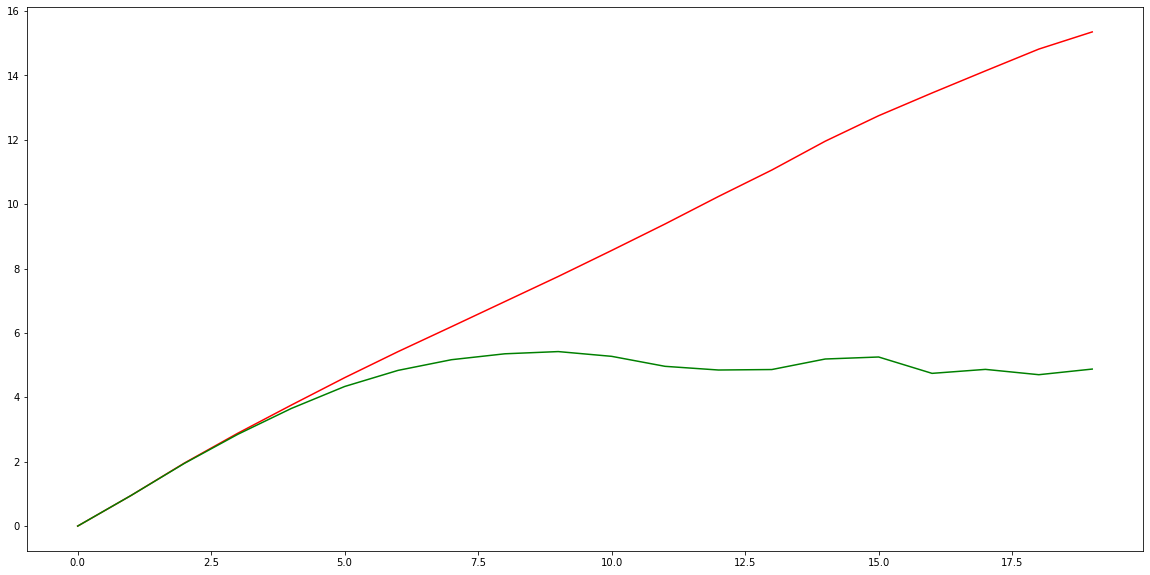

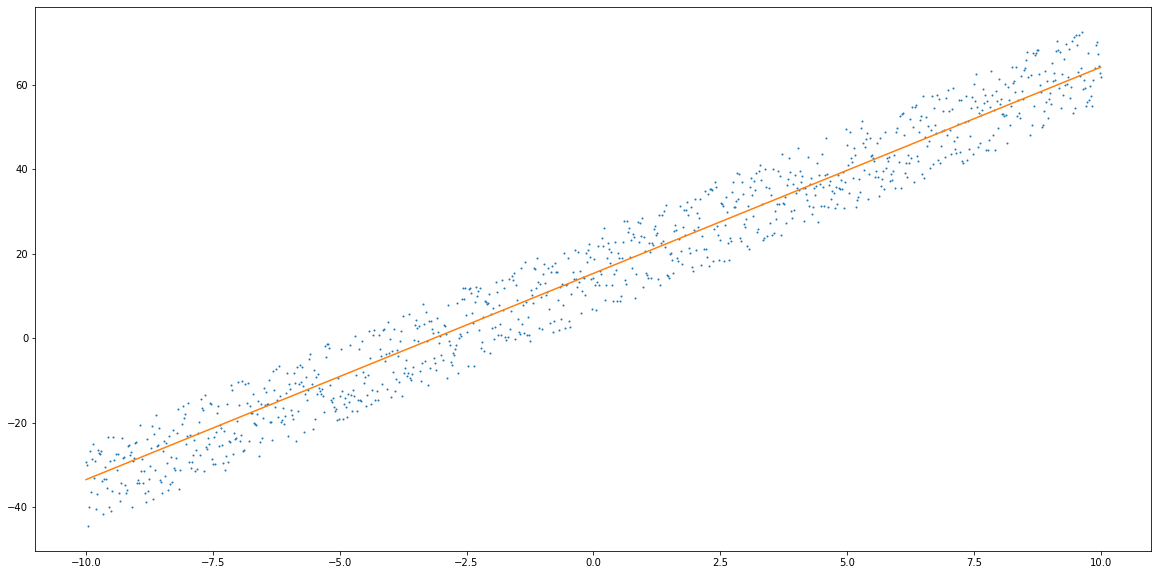

In [241]:
"""
Finds minimum of the function using stochastic gradient descent with adam.
"""
def sgd_adam(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b1:List[float], b2:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    b1, b2 = np.array(b1), np.array(b2)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    m = 0
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))

        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * np.square(g)

        m = m / (1 - np.power(b1, i))
        v = v / (1 - np.power(b2, i))

        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * m
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [15, 5]
t, ft = generate_dataset_old(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [50]
b1 = [0.5]
b2 = [0.6]
scheduler = lambda lr: lr * np.exp(-0.05)

points = sgd_adam(sum_fun, x, epoch, batch_size, lr, b1, b2, scheduler=scheduler)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## Траектория спуска обычного SGD для одномерного пространства регрессоров
На графике также отображены линии равного уровня минимизируемой функции

[ 2.08531901 -0.05698048]
[ 7.91468099 -2.94301952]
[[ 0.          0.        ]
 [ 0.38738299 -0.3718773 ]
 [ 0.83681081 -0.60958181]
 [ 1.10380947 -0.89123007]
 [ 1.40765083 -1.04223285]
 [ 1.70093676 -1.27286825]
 [ 2.07349107 -1.45558066]
 [ 2.34960525 -1.64766462]
 [ 2.58287532 -1.74863477]
 [ 2.88147904 -1.89709679]
 [ 3.20672917 -2.02806535]
 [ 3.48592638 -2.11069986]
 [ 3.73293456 -2.19886159]
 [ 3.95653985 -2.2695829 ]
 [ 4.24542608 -2.37851226]
 [ 4.51395374 -2.47214754]
 [ 4.72714351 -2.52049396]
 [ 4.95875216 -2.55083994]
 [ 5.13353032 -2.58561496]
 [ 5.38026341 -2.64171547]
 [ 5.56522145 -2.67487439]
 [ 5.71528571 -2.68458401]
 [ 5.86519706 -2.70120688]
 [ 6.0617491  -2.76466142]
 [ 6.23862751 -2.80306382]
 [ 6.37094041 -2.81343121]
 [ 6.4908562  -2.80779999]
 [ 6.64085315 -2.82620914]
 [ 6.75297456 -2.85156409]
 [ 6.88280445 -2.83461306]
 [ 7.00177082 -2.85162339]
 [ 7.1189689  -2.85687181]
 [ 7.22133284 -2.86813509]
 [ 7.34093726 -2.89550993]
 [ 7.42632953 -2.88630118]
 [ 

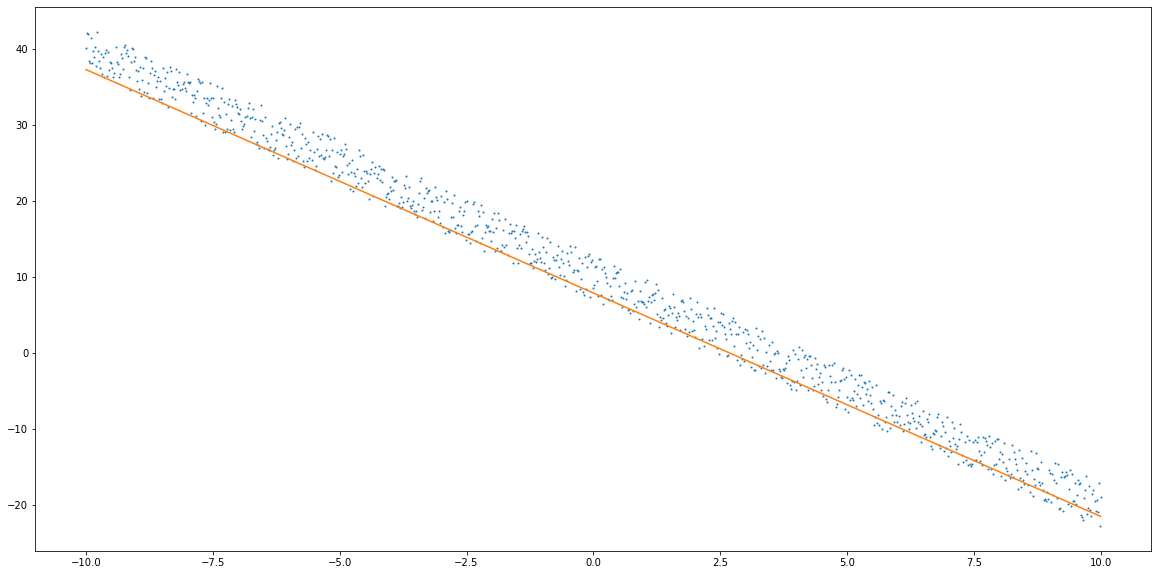

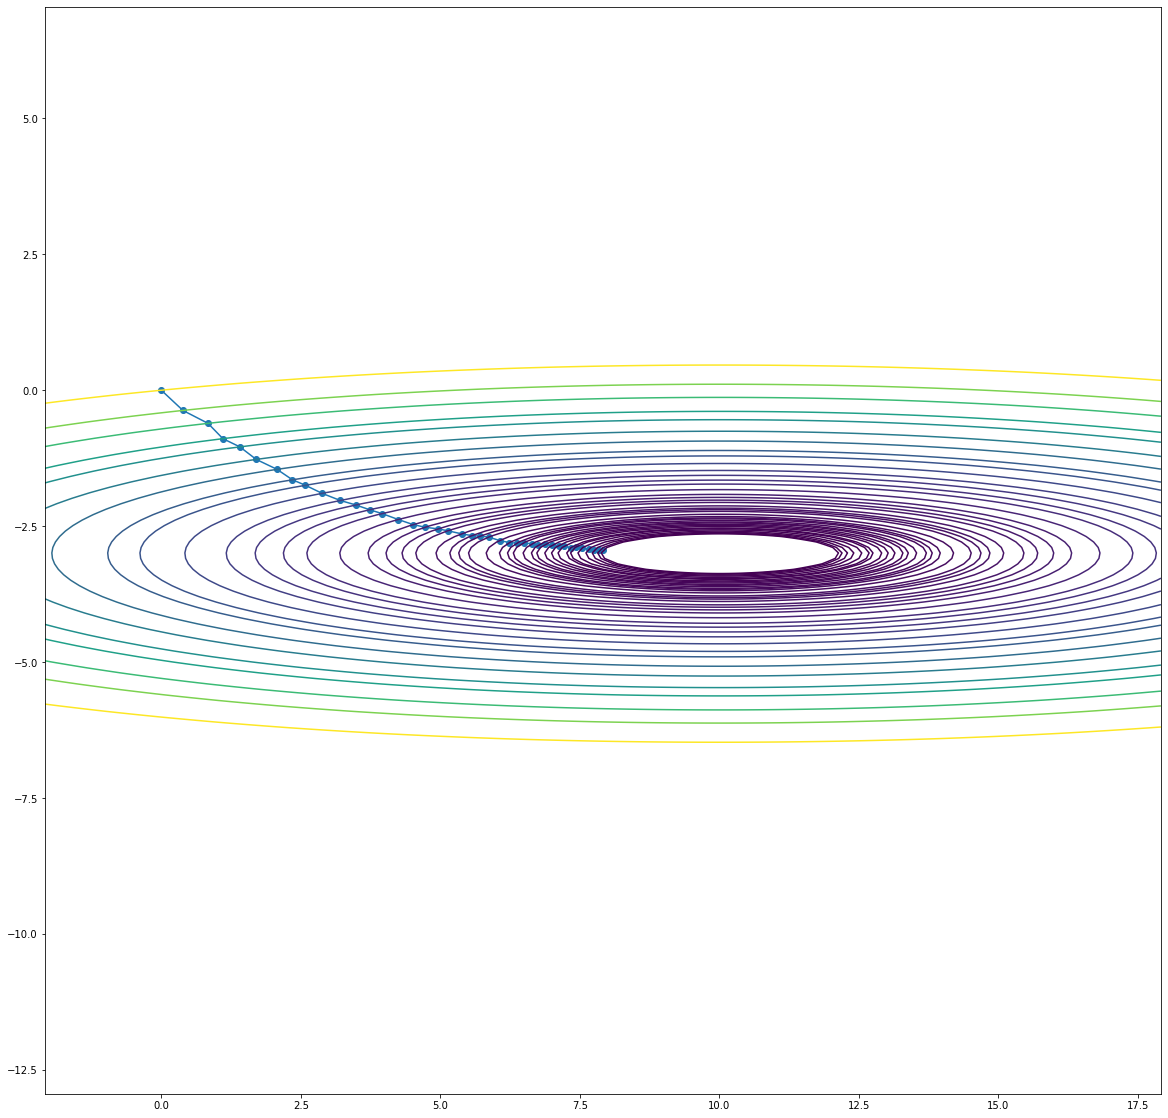

In [247]:
b = [10, -3]
t, ft = generate_dataset_old(b, 3, tt)
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 40
batch_size = 20
lr = [40, 3]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)


fun = fun_from_terms(sum_fun)

plt.plot(t, ft, 'o', markersize=1)
tt = np.linspace(-10, 10, 1000)
plt.plot(tt, min_point[1] * tt + min_point[0])

plot_path_contours(sum_fun, points, 10)